In [1]:
# Librerías generales
import numpy as np
from collections import defaultdict
from functools import reduce
from itertools import product
import random
import scipy
import matplotlib.pyplot as plt

# Librerías Qibo
import qibo
from qibo import models, gates, hamiltonians
from qibo import matrices as m

# Librerías Qiskit
import qiskit
from qiskit import IBMQ, QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile
from qiskit.visualization import plot_bloch_multivector
from qiskit.algorithms.optimizers import COBYLA, SPSA, POWELL
from qiskit.primitives import Estimator
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import X, Z, I, Y
from qiskit.circuit.library import TwoLocal
from qiskit.tools.parallel import parallel_map

random.seed()

qibo.set_backend("numpy")

%matplotlib inline

/tmp/ipykernel_18970/2196755265.py:19: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, SPSA, POWELL
[Qibo 0.1.12.dev0|INFO|2024-05-22 13:14:38]: Using numpy backend on /CPU:0


In [2]:
PAULIS = {
    "I": np.eye(2, dtype=complex),
    "X": np.array([[0,1],[1,0]], dtype=complex),
    "Y": np.array([[0,-1j],[1j,0]], dtype=complex),
    "Z": np.array([[1,0],[0,-1]], dtype=complex)
}

In [3]:
'''Qibo_code_cell'''

def ising_chain_ham_qibo(n, gam):
    
    # Esta función nos devuelve el Hamiltoniano en términos utilizables por los algoritmos de Qibo
    # n = number of spin positions
    # gam = transverse field parameter

    from qibo.symbols import X, Z

    sym_X = sum(X(i) * X(i+1) for i in range(n-1)) + (X(0) * X(n-1))
    sym_Z = sum(Z(i) for i in range(n))
    sym_H = sym_X + gam * sym_Z

    H = hamiltonians.SymbolicHamiltonian(sym_H)
    
    return H, H.matrix

In [4]:
'''Qibo_code_cell'''

# Definimos el Hamiltoniano
n = 4
gam = .3

op_H, matrix = ising_chain_ham_qibo(n,gam)

[Qibo 0.1.12.dev0|WARNING|2024-05-22 13:14:38]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


In [5]:
'''Qibo_code_cell'''

# Ahora creamos un circuito variacional de ansatz
# En este caso usamos un circuito de puertas RY(theta) y CZ, haciendo los diferentes valores de theta aleatorios

nqubits = n
nlayers  = 8

circuit = models.Circuit(nqubits)

for l in range(nlayers):
    circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))
    circuit.add((gates.CZ(q, q+1) for q in range(0, nqubits-1, 2)))
    circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))
    circuit.add((gates.CZ(q, q+1) for q in range(1, nqubits-2, 2)))
    circuit.add(gates.CZ(0, nqubits-1))
    
circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))

In [6]:
'''Qibo_code_cell'''

# Especificamos el algorimto de optimización clásica
# opt = 'COBYLA'
opt = 'Powell'

In [7]:
'''Qibo_code_cell'''

# Esto son funciones auxiliares para guardar los datos de las iteraciones

intermediate_info = {
    'parameters': [],
    'energy': [],
    #'stddev': []
}

def callback(p):
    intermediate_info['parameters'].append(p)    
    energy, _, _ = vqe.minimize(p, callback = None, method=opt, options = None, compile=False)
    intermediate_info['energy'].append(energy)
    #intermediate_info['stddev'].append(stddev)

In [8]:
'''Qibo_code_cell'''

# Parámetros del Ansatz
initial_parameters = np.random.uniform(-2*np.pi, 2*np.pi, 2*nqubits*nlayers + nqubits)

# Construcción del método VQE
vqe = models.VQE(circuit, op_H)
options = {'disp': True, 'return_all': True}

# Y ejecutamos el algoritmo
best, params, extra = vqe.minimize(initial_parameters, callback = callback, method=opt, options = options, compile=False)

values = intermediate_info['energy']

Optimization terminated successfully.
         Current function value: -4.089306
         Iterations: 3
         Function evaluations: 1871


In [9]:
# Y ya vemos el valor de la solución:
print("E_G =",best)

E_G = -4.089305581262189


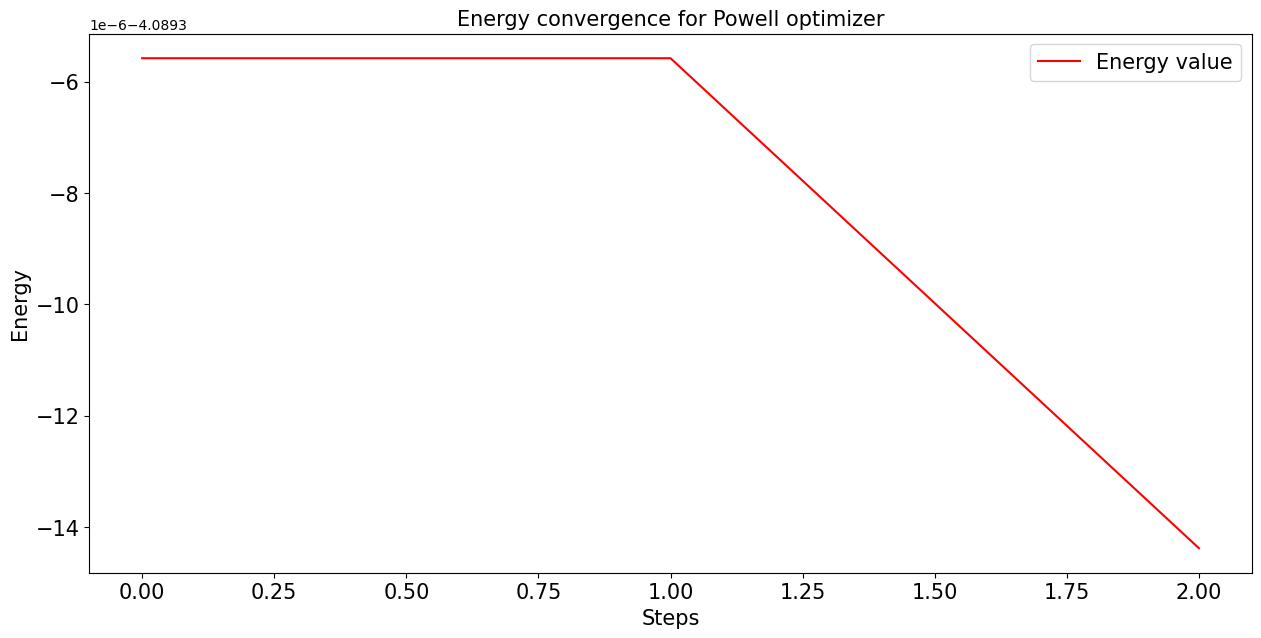

In [10]:
# Con la información de las iteraciones podemos dibujar la convergencia de nuestro código

fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(values)), values, label="Energy value", color='red')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)
plt.title('Energy convergence for Powell optimizer', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()

In [11]:
eigvals, eigvecs = scipy.linalg.eig(matrix)

print("E_G =", min(eigvals).real)

print("Error relativo =", abs((best - min(eigvals).real)/min(eigvals).real) * 100, "%")

E_G = -4.092961599426855
Error relativo = 0.08932451663308086 %
